In [4]:
from sklearn.neighbors import kneighbors_graph
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random 
import pandas as pd
import math
import statistics
import string

In [5]:
X = np.array([[1,2],[1,5],[3,4], [4,2],[6,5],[0,4] , [7,4]])

In [6]:
A = kneighbors_graph(X, 4, mode='connectivity', include_self=True)

In [7]:
adjacency_matrix = A.toarray()
adjacency_matrix

array([[1., 0., 1., 1., 0., 1., 0.],
       [1., 1., 1., 0., 0., 1., 0.],
       [1., 1., 1., 1., 0., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 0., 1., 0.],
       [0., 0., 1., 1., 1., 0., 1.]])

In [8]:
def generatePoints(n, minX=0, maxX=1000, minY=0, maxY=1000):
    points = []
    for i in range(n):
        x = random.randint(minX,maxX)
        y = random.randint(minY, maxY)
        points.append([x,y])
    return np.array(points)

In [9]:
points = generatePoints(50)
adjacency_matrix2 = kneighbors_graph(points, 5, mode='connectivity', include_self=True).toarray()

(-1.1180050159435233,
 1.1180050329308466,
 -1.1248369431765075,
 1.1248369425010933)

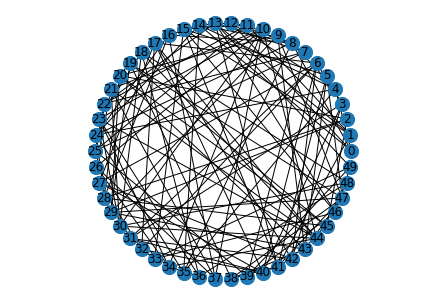

In [10]:
G2 = nx.from_numpy_matrix(adjacency_matrix2)
nx.draw_circular(G2, node_size=200, with_labels=True)
plt.axis('equal')

In [11]:
G=nx.Graph()

G.add_edge('a','b',weight=0.6)
G.add_edge('a','c',weight=0.2)
G.add_edge('c','d',weight=0.1)
G.add_edge('c','e',weight=0.7)
G.add_edge('c','f',weight=0.9)
G.add_edge('a','d',weight=0.3)

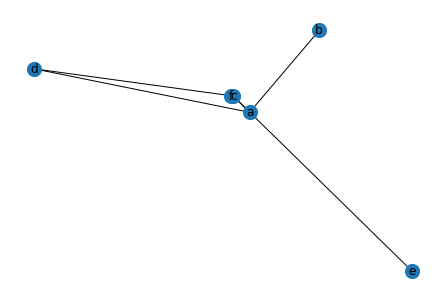

In [12]:
nx.draw_random(G, node_size=200, with_labels=True)

In [13]:
# Function to sort the list by second item of tuple 
def Sort_Tuple(tup_list):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    return(sorted(tup_list, key = lambda x: x[1])) 


In [148]:
def matrixToDf(M, nodes):
    df = pd.DataFrame(M, columns = nodes, index=nodes)
    return df

def kNearestNeighbors(df, k=2, flag=0):
    # dictionary with (key = node, value = list of K nearest neighbors) pairs
    nearestDict = {}
    # labels of the nodes
    nodes = list(df.columns.values)
    
    for rowNum in range(len(df)):
        # distances from the current node
        neighborDistances = df.iloc[rowNum]
        
        # list of tuples of the form (current node, distance from nodes[nodeNum] to current node)
        labelledNeighbors = [] 
        for i in range(len(neighborDistances)):
            labelledNeighbors.append((nodes[i], neighborDistances[i]))
        sortedNearestNeighbors = Sort_Tuple(labelledNeighbors)
        kNearest = []
        for idx in range(1,k+1):
            # appends the nearest K neighboring nodes to kNearest list
            kNearest.append(sortedNearestNeighbors[idx][flag]) 
        nearestDict[nodes[rowNum]] = kNearest
    return nearestDict

def kNearestNeighborsAdjMatrix(df, k=2):
    nodes = list(df.columns.values)
    numNodes = len(nodes)
    adjDf = matrixToDf(np.zeros([numNodes, numNodes]), nodes)
    nearestDict = kNearestNeighbors(df, k)
    for node in nearestDict:
        nearest = nearestDict[node]
        for neighbor in nearest:
            adjDf.at[node, neighbor] = 1
    return adjDf

In [149]:
M = np.array([[0, 12, 9, 12],
             [4, 0, 6, 8],
             [13, 5, 0, 1],
             [9, 7, 2, 0]])
df = matrixToDf(M,  ['a','b','c','d'])
kNearestNeighbors(df,1 )

{'a': ['c'], 'b': ['a'], 'c': ['d'], 'd': ['c']}

In [150]:
kNearestNeighborsAdjMatrix(df)

,a,b,c,d
a,0.0,1.0,1.0,0.0
b,1.0,0.0,1.0,0.0
c,0.0,1.0,0.0,1.0
d,0.0,1.0,1.0,0.0


In [173]:
def elbowPlot(df):
    numNodes = len(df)
    sseList = []
    for k in range(1,numNodes):
        # sum the square distance over all K nearest neighbors for each node
        sse = 0
        nearestNeighborsDict = kNearestNeighbors(df, k)
        for node in nearestNeighborsDict:
            listOfNN = nearestNeighborsDict[node]
            distancesOfNN = kNearestNeighbors(df, k, 1)
            avg = np.mean(distancesOfNN[node])
            for neighbor in listOfNN:
                sse += (df.at[node, neighbor] - avg)**2
        sseList.append((k, sse))
    
    plt.plot(*zip(*sseList))
    plt.show()
    

In [174]:
def optK(df):
    numNodes = len(df)
    sseList = []
    for k in range(1,numNodes):
        # sum the square distance over all K nearest neighbors for each node
        sse = 0
        nearestNeighborsDict = kNearestNeighbors(df, k)
        for node in nearestNeighborsDict:
            listOfNN = nearestNeighborsDict[node]
            distancesOfNN = kNearestNeighbors(df, k, 1)
            avg = np.mean(distancesOfNN[node])
            for neighbor in listOfNN:
                sse += (df.at[node, neighbor] - avg)**2
        sseList.append((k, sse))
    # returns k*, the optimum k
    k_opt = optimumKHelper(sseList)
    return k_opt

In [175]:
def findNearbyBlocks(df):
    k_opt = optK(df)
    # flag = 0 (by default) returns the names of the NN blocks
    namesOfNN = kNearestNeighbors(df, k_opt)
    for node in namesOfNN.keys():
        english = "The nearest blocks of " + str(node) + " are "
        for neighbor in namesOfNN[node]:
             english += str(neighbor) + ", "
        english = english[:-2] + "."
        print(english)

In [176]:
findNearbyBlocks(df)

The nearest blocks of 0 are 0, 4.
The nearest blocks of 1 are 4, 0.
The nearest blocks of 2 are 3, 1.
The nearest blocks of 3 are 2, 1.
The nearest blocks of 4 are 2, 0.


In [194]:
def optimumKHelper(sseList):
    # first point (k=1,sse(k))
    S = sseList[0]
    S_x, S_y = S[0], S[1]
    # terminal point (k=n, sse(n))
    T = sseList[-1]
    T_x, T_y = T[0], T[1]
    computations = []
    for i in range(len(sseList)):
        P = sseList[i]
        
        P_x = sseList[i][0]
        P_y = sseList[i][1]
        
        # prevent division by 0
        if T_x != P_x and P_x != S_x:
            formula = ((T_y - P_y) / (T_x - P_x)) - ((P_y - S_y) / (P_x - S_x))
            computations.append((i, formula))
 
    sorted_comps = Sort_Tuple(computations)
    # even number of points
    n = len(sorted_comps)
    if n % 2 == 0:
        med = math.floor((sorted_comps[math.floor(n/2)][0] + sorted_comps[math.ceil(n/2)][0]) / 2)
    else:
        med = sorted_comps[int(n/2)][0]
    return med

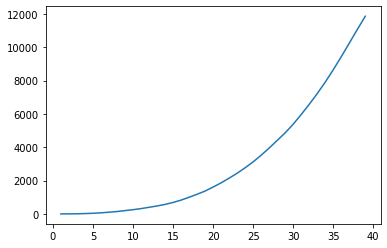

19

In [200]:
n = 40
df = matrixToDf(np.random.randint(10, 0, size=(n,n)), nodes = range(n))
elbowPlot(df)
optK(df)

In [147]:
findNearbyBlocks(df)

[(1, 3253.9078933308365), (2, 3452.831989068741), (3, 3527.529606314855), (4, 3597.539210672405), (5, 3807.987428523314), (6, 4279.559165418726), (7, 5035.302252076831), (8, 5403.514913713563), (9, 6332.722093426012)]
The nearest blocks of 0 are 3, 8, 5, 1, 2, 10.
The nearest blocks of 1 are 11, 3, 7, 6, 9, 0.
The nearest blocks of 2 are 5, 9, 0, 4, 11, 10.
The nearest blocks of 3 are 1, 11, 10, 3, 6, 7.
The nearest blocks of 4 are 0, 4, 6, 7, 10, 8.
The nearest blocks of 5 are 6, 3, 11, 8, 4, 10.
The nearest blocks of 6 are 2, 8, 7, 6, 5, 9.
The nearest blocks of 7 are 4, 9, 3, 1, 7, 11.
The nearest blocks of 8 are 9, 5, 3, 0, 6, 8.
The nearest blocks of 9 are 5, 1, 4, 2, 11, 6.
The nearest blocks of 10 are 10, 11, 6, 3, 5, 2.
The nearest blocks of 11 are 9, 5, 0, 10, 4, 11.


In [807]:
adjMatrix = kNearestNeighborsAdjMatrix(df)

In [808]:
#G = nx.from_pandas_edgelist(adjMatrix)
#nx.draw_random(G, node_size=200, with_labels=True)
#plt.axis('equal')

In [106]:
def createM(points):
    n = len(points)
    M = np.zeros([n,n])
    for i in range(n):
        p1 = points[i]
        for j in range(n):
            p2 = points[j]
            M[i][j] = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    return M
        

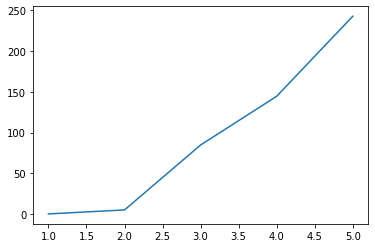

In [131]:
points = [(0,0),(1,1),(0.5,0.5),(5,5),(4,5),(6.7,7)]
nodes = list(string.ascii_lowercase)[:len(points)]
M = createM(points)
df = matrixToDf(M, nodes)
elbowPlot(df)

In [132]:
optK(df)

[(2, 36.76159774659828), (3, 50.10253862891965), (1, 74.43268955377008)]


(1, 74.43268955377008)